# Assignment 1 - Code Example - Part A

This code baseline is inspired by and modified from [this great tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).

This code can achieve an accuracy of approximately 86.50% on CIFAR-10. Please set up the environment and run your experiments starting from this baseline. You are expected to achieve an accuracy higher than this baseline.

In [1]:
# import some necessary packages
#!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.datasets as tv_datasets
import torchvision.transforms as tv_transforms
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    print("CUDA Version:", torch.version.cuda)
    print("CUDA Device:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available.")

print(f"PyTorch Version: {torch.__version__}")
import torchvision
print(f"torchvision Version: {torchvision.__version__}")

CUDA Version: 12.1
CUDA Device: Tesla P100-PCIE-16GB
PyTorch Version: 2.5.1+cu121
torchvision Version: 0.20.1+cu121


## 1. Baseline Model
### 1.1 Settings

In [3]:
# # some experimental setup
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# num_epochs = 128
# batch_size = 64
# print_every = 200

# optim_name = "Adam"
# optim_kwargs = dict(
#     lr=3e-4,
#     weight_decay=1e-6,
# )

In [4]:
# # prepare datasets
# # preprocessing pipeline for input images
# transformation = dict()
# for data_type in ("train", "test"):
#     is_train = data_type=="train"
#     transformation[data_type] = tv_transforms.Compose(([
#         tv_transforms.RandomRotation(degrees=15),
#         tv_transforms.RandomHorizontalFlip(),
#         tv_transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
#     ] if is_train else []) + 
#     [
#         tv_transforms.ToTensor(),
#         tv_transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
#     ])
    
# num_workers = 2
# dataset, loader = {}, {}
# for data_type in ("train", "test"):
#     is_train = data_type=="train"
#     dataset[data_type] = tv_datasets.CIFAR10(
#         root="./data", train=is_train, download=True, transform=transformation[data_type],
#     )
#     loader[data_type] = torch.utils.data.DataLoader(
#         dataset[data_type], batch_size=batch_size, shuffle=is_train, num_workers=num_workers,
#     )


In [5]:
# # our network architecture
# net = nn.Sequential(
#     nn.Conv2d(3, 128, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.Dropout(0.3),
#     nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.Dropout(0.3),
#     nn.Conv2d(256, 512, 3, padding=1), nn.ReLU(inplace=True),
#     nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),
#     nn.Conv2d(512, 256, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.Dropout(0.3),
#     nn.Flatten(),
#     nn.Linear(256 * 4 * 4, 512), nn.ReLU(inplace=True), nn.Dropout(0.5),
#     nn.Linear(512, 256), nn.ReLU(inplace=True), nn.Dropout(0.5),
#     nn.Linear(256, 128), nn.ReLU(inplace=True), nn.Dropout(0.5),
#     nn.Linear(128, 10),
# )

# # move to device
# net.to(device)

# # print the number of parameters
# print(f"number of parameters: {sum(p.numel() for p in net.parameters() if p.requires_grad) / 1_000_000:.2f}M")

### 1.2 Start Training

In [6]:
# # the network optimizer
# optimizer = getattr(optim, optim_name)(net.parameters(), **optim_kwargs)

# # loss function
# criterion = nn.CrossEntropyLoss()

# # training loop
# net.train()
# for epoch in range(num_epochs):

#     running_loss = 0.0
#     for i, (img, target) in enumerate(loader["train"]):
#         img, target = img.to(device), target.to(device)

#         pred = net(img)
#         loss = criterion(pred, target)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         if i % print_every == print_every - 1:
#             print(f"[epoch={epoch + 1:3d}, iter={i + 1:5d}] loss: {running_loss / print_every:.3f}")
#             running_loss = 0.0

# print("Finished Training")

### 1.3 Evaluating its accuracy

In [7]:
# net.eval()
# correct, total = 0, 0
# with torch.no_grad():
#     for img, target in loader["test"]:
#         img, target = img.to(device), target.to(device)
        
#         # make prediction
#         pred = net(img)
        
#         # accumulate
#         total += len(target)
#         correct += (torch.argmax(pred, dim=1) == target).sum().item()

# print(f"Accuracy of the network on the {total} test images: {100 * correct / total:.2f}%")

## 2. Variant 1
Adding batchnorm dropping the dropout layers in conv blocks, and decreasing the dropout ratio in linear layers.  
Time consuming: 50m   
last loss: 0.033   
Test acc: 89.31%

In [8]:
# # some experimental setup
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# num_epochs = 128
# batch_size = 64
# print_every = 200

# optim_name = "Adam"
# optim_kwargs = dict(
#     lr=3e-4,
#     weight_decay=1e-6,
# )

In [9]:
# # prepare datasets
# # preprocessing pipeline for input images
# transformation = dict()
# for data_type in ("train", "test"):
#     is_train = data_type=="train"
#     transformation[data_type] = tv_transforms.Compose(([
#         tv_transforms.RandomRotation(degrees=15),
#         tv_transforms.RandomHorizontalFlip(),
#         tv_transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
#     ] if is_train else []) + 
#     [
#         tv_transforms.ToTensor(),
#         tv_transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
#     ])
    
# num_workers = 2
# dataset, loader = {}, {}
# for data_type in ("train", "test"):
#     is_train = data_type=="train"
#     dataset[data_type] = tv_datasets.CIFAR10(
#         root="./data", train=is_train, download=True, transform=transformation[data_type],
#     )
#     loader[data_type] = torch.utils.data.DataLoader(
#         dataset[data_type], batch_size=batch_size, shuffle=is_train, num_workers=num_workers,
#     )


In [10]:
# # our network architecture
# net = nn.Sequential(
#     nn.Conv2d(3, 128, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2),nn.BatchNorm2d(128),
#     nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2),nn.BatchNorm2d(256),
#     nn.Conv2d(256, 512, 3, padding=1), nn.ReLU(inplace=True),nn.BatchNorm2d(512),
#     nn.Conv2d(512, 512, 3, padding=1), nn.ReLU(inplace=True),nn.BatchNorm2d(512),
#     nn.Conv2d(512, 256, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2),nn.BatchNorm2d(256),
#     nn.Flatten(),
#     nn.Linear(256 * 4 * 4, 512), nn.ReLU(inplace=True), nn.Dropout(0.3),nn.BatchNorm1d(512),
#     nn.Linear(512, 256), nn.ReLU(inplace=True), nn.Dropout(0.3),nn.BatchNorm1d(256),
#     nn.Linear(256, 128), nn.ReLU(inplace=True), nn.Dropout(0.3),nn.BatchNorm1d(128),
#     nn.Linear(128, 10),
# )

# # move to device
# net.to(device)

# # print the number of parameters
# print(f"number of parameters: {sum(p.numel() for p in net.parameters() if p.requires_grad) / 1_000_000:.2f}M")

In [11]:
# # the network optimizer
# optimizer = getattr(optim, optim_name)(net.parameters(), **optim_kwargs)

# # loss function
# criterion = nn.CrossEntropyLoss()

# # 训练循环
# losses = []
# accuracies = []
# test_losses = []

# for epoch in range(num_epochs):
#     # 训练阶段
#     net.train()
#     running_loss = 0.0
#     for i, (img, target) in enumerate(loader["train"]):
#         img, target = img.to(device), target.to(device)
        
#         pred = net(img)
#         loss = criterion(pred, target)
        
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         running_loss += loss.item()
        
#         if i % print_every == print_every - 1:
#             print(f"[epoch={epoch + 1:3d}, iter={i + 1:5d}] training loss: {running_loss / print_every:.3f}")
#             running_loss = 0.0
    
#     # 每个epoch结束后进行一次评估
#     net.eval()
#     test_loss = 0.0
#     correct = 0
#     total = 0
    
#     with torch.no_grad():
#         for img, target in loader["test"]:
#             img, target = img.to(device), target.to(device)
            
#             pred = net(img)
#             loss = criterion(pred, target)
            
#             test_loss += loss.item()
#             total += len(target)
#             correct += (torch.argmax(pred, dim=1) == target).sum().item()
    
#     # 计算平均损失和准确率
#     avg_test_loss = test_loss / len(loader["test"])
#     accuracy = correct / total
    
#     # 记录结果
#     losses.append(running_loss / print_every)
#     accuracies.append(accuracy)
#     test_losses.append(avg_test_loss)
    
#     print(f"Epoch {epoch + 1}: Test Loss: {avg_test_loss:.3f}, Accuracy: {100 * accuracy:.2f}%")

# print("Finished Training")

In [12]:
# import pandas as pd
# import matplotlib.pyplot as plt

# results_df = pd.DataFrame({
#     'Epoch': range(1, num_epochs + 1),
#     'Training Loss': losses,
#     'Test Loss': test_losses,
#     'Test Accuracy': accuracies
# })

# results_df.to_excel('training_results_Variant1.xlsx', index=False)

# # 可视化
# plt.figure(figsize=(18, 5))

# # 训练损失曲线
# plt.subplot(1, 3, 1)
# plt.plot(results_df['Epoch'], results_df['Training Loss'], label='Training Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training Loss')
# plt.legend()

# # 测试损失曲线
# plt.subplot(1, 3, 2)
# plt.plot(results_df['Epoch'], results_df['Test Loss'], label='Test Loss', color='orange')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Test Loss')
# plt.legend()

# # 测试准确率曲线
# plt.subplot(1, 3, 3)
# plt.plot(results_df['Epoch'], results_df['Test Accuracy'], label='Test Accuracy', color='green')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('Test Accuracy')
# plt.legend()

# plt.tight_layout()
# plt.savefig('training_results_Variant1.jpg')
# plt.show()

In [13]:
# # save model
# torch.save(net.state_dict(), 'Variant1_3.pth')
# # save model info
# model_info = {
#     "Optimizer": type(optimizer).__name__,
#     "Learning Rate": optimizer.param_groups[0]['lr'],
#     "Weight Decay": optimizer.param_groups[0]['weight_decay'],
#     "Network Architecture": str(net)
# }

# model_info_df = pd.DataFrame([model_info])
# model_info_df.to_excel('model_info_variant1.xlsx', index=False)

In [14]:
# # evaluation
# net.eval()
# correct, total = 0, 0
# with torch.no_grad():
#     for img, target in loader["test"]:
#         img, target = img.to(device), target.to(device)
        
#         # make prediction
#         pred = net(img)
        
#         # accumulate
#         total += len(target)
#         correct += (torch.argmax(pred, dim=1) == target).sum().item()

# print(f"Accuracy of the network on the {total} test images: {100 * correct / total:.2f}%")

## 3. Variant 2  
Add 2 more Conv layers and use wider nets.  
Time: 70min   
last loss: 0.042  
Test acc: 89.60%

In [15]:
# # some experimental setup
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# num_epochs = 64
# batch_size = 64
# print_every = 200

# optim_name = "Adam"
# optim_kwargs = dict(
#     lr=3e-4,
#     weight_decay=1e-6,
# )

In [16]:
# # prepare datasets
# # preprocessing pipeline for input images
# transformation = dict()
# for data_type in ("train", "test"):
#     is_train = data_type=="train"
#     transformation[data_type] = tv_transforms.Compose(([
#         tv_transforms.RandomRotation(degrees=15),
#         tv_transforms.RandomHorizontalFlip(),
#         tv_transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
#     ] if is_train else []) + 
#     [
#         tv_transforms.ToTensor(),
#         tv_transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
#     ])
    
# num_workers = 2
# dataset, loader = {}, {}
# for data_type in ("train", "test"):
#     is_train = data_type=="train"
#     dataset[data_type] = tv_datasets.CIFAR10(
#         root="./data", train=is_train, download=True, transform=transformation[data_type],
#     )
#     loader[data_type] = torch.utils.data.DataLoader(
#         dataset[data_type], batch_size=batch_size, shuffle=is_train, num_workers=num_workers,
#     )


In [17]:
# # our network architecture
# net = nn.Sequential(
#     nn.Conv2d(3, 256, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.BatchNorm2d(256),
#     nn.Conv2d(256, 512, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.BatchNorm2d(512),
#     nn.Conv2d(512, 1024, 3, padding=1), nn.ReLU(inplace=True), nn.BatchNorm2d(1024),
#     nn.Conv2d(1024, 1024, 3, padding=1), nn.ReLU(inplace=True), nn.BatchNorm2d(1024),
#     nn.Conv2d(1024, 2048, 3, padding=1), nn.ReLU(inplace=True), nn.BatchNorm2d(2048),
#     nn.Conv2d(2048, 2048, 3, padding=1), nn.ReLU(inplace=True), nn.BatchNorm2d(2048),
#     nn.Conv2d(2048, 1024, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.BatchNorm2d(1024),
    
#     nn.Flatten(),
    
#     nn.Linear(1024 * 4 * 4, 2048), nn.ReLU(inplace=True), nn.Dropout(0.3), nn.BatchNorm1d(2048),
#     nn.Linear(2048, 1024), nn.ReLU(inplace=True), nn.Dropout(0.3), nn.BatchNorm1d(1024),
#     nn.Linear(1024, 512), nn.ReLU(inplace=True), nn.Dropout(0.3), nn.BatchNorm1d(512),
#     nn.Linear(512, 10),
# )

# # move to device
# net.to(device)

# # print the number of parameters
# print(f"number of parameters: {sum(p.numel() for p in net.parameters() if p.requires_grad) / 1_000_000:.2f}M")

In [18]:
# # the network optimizer
# optimizer = getattr(optim, optim_name)(net.parameters(), **optim_kwargs)

# # loss function
# criterion = nn.CrossEntropyLoss()

# # 训练循环
# losses = []
# accuracies = []
# test_losses = []

# for epoch in range(num_epochs):
#     # 训练阶段
#     net.train()
#     running_loss = 0.0
#     for i, (img, target) in enumerate(loader["train"]):
#         img, target = img.to(device), target.to(device)
        
#         pred = net(img)
#         loss = criterion(pred, target)
        
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         running_loss += loss.item()
        
#         if i % print_every == print_every - 1:
#             print(f"[epoch={epoch + 1:3d}, iter={i + 1:5d}] training loss: {running_loss / print_every:.3f}")
#             running_loss = 0.0
    
#     # 每个epoch结束后进行一次评估
#     net.eval()
#     test_loss = 0.0
#     correct = 0
#     total = 0
    
#     with torch.no_grad():
#         for img, target in loader["test"]:
#             img, target = img.to(device), target.to(device)
            
#             pred = net(img)
#             loss = criterion(pred, target)
            
#             test_loss += loss.item()
#             total += len(target)
#             correct += (torch.argmax(pred, dim=1) == target).sum().item()
    
#     # 计算平均损失和准确率
#     avg_test_loss = test_loss / len(loader["test"])
#     accuracy = correct / total
    
#     # 记录结果
#     losses.append(running_loss / print_every)
#     accuracies.append(accuracy)
#     test_losses.append(avg_test_loss)
    
#     print(f"Epoch {epoch + 1}: Test Loss: {avg_test_loss:.3f}, Accuracy: {100 * accuracy:.2f}%")

# print("Finished Training")

In [19]:
# import pandas as pd
# import matplotlib.pyplot as plt

# results_df = pd.DataFrame({
#     'Epoch': range(1, num_epochs + 1),
#     'Training Loss': losses,
#     'Test Loss': test_losses,
#     'Test Accuracy': accuracies
# })

# results_df.to_excel('training_results_Variant2.xlsx', index=False)

# # 可视化
# plt.figure(figsize=(18, 5))

# # 训练损失曲线
# plt.subplot(1, 3, 1)
# plt.plot(results_df['Epoch'], results_df['Training Loss'], label='Training Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training Loss')
# plt.legend()

# # 测试损失曲线
# plt.subplot(1, 3, 2)
# plt.plot(results_df['Epoch'], results_df['Test Loss'], label='Test Loss', color='orange')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Test Loss')
# plt.legend()

# # 测试准确率曲线
# plt.subplot(1, 3, 3)
# plt.plot(results_df['Epoch'], results_df['Test Accuracy'], label='Test Accuracy', color='green')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('Test Accuracy')
# plt.legend()

# plt.tight_layout()
# plt.savefig('training_results_Variant2.jpg')
# plt.show()

In [20]:
# # save model
# torch.save(net.state_dict(), 'Variant2.pth')
# # save model info
# model_info = {
#     "Optimizer": type(optimizer).__name__,
#     "Learning Rate": optimizer.param_groups[0]['lr'],
#     "Weight Decay": optimizer.param_groups[0]['weight_decay'],
#     "Network Architecture": str(net)
# }

# model_info_df = pd.DataFrame([model_info])
# model_info_df.to_excel('model_info_variant2.xlsx', index=False)

In [21]:
# # evaluation
# net.eval()
# correct, total = 0, 0
# with torch.no_grad():
#     for img, target in loader["test"]:
#         img, target = img.to(device), target.to(device)
        
#         # make prediction
#         pred = net(img)
        
#         # accumulate
#         total += len(target)
#         correct += (torch.argmax(pred, dim=1) == target).sum().item()

# print(f"Accuracy of the network on the {total} test images: {100 * correct / total:.2f}%")

## 4. Variant 3
Adding residual connections to be a ResNet, which allows the network to be deeper while avoiding the problems of vanishing or exploding gradients.  
ResNet34:  
Time consuming: 1h13m  
last loss: 0.129  
Test acc: 84.33%

In [22]:
# # some experimental setup
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# num_epochs = 64
# batch_size = 64
# print_every = 200

# optim_name = "Adam"
# optim_kwargs = dict(
#     lr=3e-4,
#     weight_decay=1e-6,
# )

In [23]:
# # prepare datasets
# # preprocessing pipeline for input images
# transformation = dict()
# for data_type in ("train", "test"):
#     is_train = data_type=="train"
#     transformation[data_type] = tv_transforms.Compose(([
#         tv_transforms.RandomRotation(degrees=15),
#         tv_transforms.RandomHorizontalFlip(),
#         tv_transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
#     ] if is_train else []) + 
#     [
#         tv_transforms.ToTensor(),
#         tv_transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
#     ])
    
# num_workers = 2
# dataset, loader = {}, {}
# for data_type in ("train", "test"):
#     is_train = data_type=="train"
#     dataset[data_type] = tv_datasets.CIFAR10(
#         root="./data", train=is_train, download=True, transform=transformation[data_type],
#     )
#     loader[data_type] = torch.utils.data.DataLoader(
#         dataset[data_type], batch_size=batch_size, shuffle=is_train, num_workers=num_workers,
#     )


In [24]:
# # ResNet 34
# # 定义基本的残差块
# class ResBlock(nn.Module):
#     expansion = 1

#     def __init__(self, in_channels, out_channels, stride=1):
#         super(ResBlock, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
#         self.bn1 = nn.BatchNorm2d(out_channels)
#         self.relu = nn.ReLU(inplace=True)
#         self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
#         self.bn2 = nn.BatchNorm2d(out_channels)

#         self.shortcut = nn.Sequential()
#         if stride != 1 or in_channels != self.expansion * out_channels:
#             self.shortcut = nn.Sequential(
#                 nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(self.expansion * out_channels)
#             )

#     def forward(self, x):
#         out = self.relu(self.bn1(self.conv1(x)))
#         out = self.bn2(self.conv2(out))
#         out += self.shortcut(x)
#         out = self.relu(out)
#         return out

# # 定义ResNet34模型
# class ResNet34(nn.Module):
#     def __init__(self, num_classes=1000):
#         super(ResNet34, self).__init__()
#         self.in_channels = 64

#         self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
#         self.bn1 = nn.BatchNorm2d(64)
#         self.relu = nn.ReLU(inplace=True)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

#         self.layer1 = self._make_layer(64, 3, stride=1)
#         self.layer2 = self._make_layer(128, 4, stride=2)
#         self.layer3 = self._make_layer(256, 6, stride=2)
#         self.layer4 = self._make_layer(512, 3, stride=2)

#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc = nn.Linear(512 * ResBlock.expansion, num_classes)

#     def _make_layer(self, out_channels, num_blocks, stride):
#         strides = [stride] + [1] * (num_blocks - 1)
#         layers = []
#         for stride in strides:
#             layers.append(ResBlock(self.in_channels, out_channels, stride))
#             self.in_channels = out_channels * ResBlock.expansion
#         return nn.Sequential(*layers)

#     def forward(self, x):
#         out = self.relu(self.bn1(self.conv1(x)))
#         out = self.maxpool(out)
#         out = self.layer1(out)
#         out = self.layer2(out)
#         out = self.layer3(out)
#         out = self.layer4(out)
#         out = self.avgpool(out)
#         out = torch.flatten(out, 1)
#         out = self.fc(out)
#         return out


# net = ResNet34(num_classes=10)

# # move to device
# net.to(device)

# # print the number of parameters
# print(f"number of parameters: {sum(p.numel() for p in net.parameters() if p.requires_grad) / 1_000_000:.2f}M")

In [25]:
# # 定义基本的残差块
# class ResBlock(nn.Module):
#     def __init__(self, in_channels, out_channels, stride=1):
#         super(ResBlock, self).__init__()
#         # 主路径
#         self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
#         self.bn1 = nn.BatchNorm2d(out_channels)
#         self.relu = nn.ReLU(inplace=False)
        
#         # 残差路径
#         self.shortcut = nn.Sequential()
#         if stride != 1 or in_channels != out_channels:
#             self.shortcut = nn.Sequential(
#                 nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
#                 nn.BatchNorm2d(out_channels)
#             )

#     def forward(self, x):
#         identity = x
        
#         out = self.bn1(self.conv1(x))
#         out = self.relu(out)
        
#         # 添加残差连接
#         out = out + self.shortcut(identity)
#         out = self.relu(out)
        
#         return out

# # 网络结构
# net = nn.Sequential(
#     # 第一个卷积块 - 保持与Variant2相同的起始通道数
#     nn.Conv2d(3, 256, 3, padding=1), nn.ReLU(inplace=True), nn.BatchNorm2d(256),
#     ResBlock(256, 256),  # 添加残差连接
#     nn.MaxPool2d(2),
    
#     # 第二个卷积块 - 基于Variant2的通道数
#     ResBlock(256, 512),
#     ResBlock(512, 512),
#     nn.MaxPool2d(2),
    
#     # 第三个卷积块
#     ResBlock(512, 1024),
#     ResBlock(1024, 1024),
    
#     # 第四个卷积块
#     ResBlock(1024, 2048),
#     ResBlock(2048, 2048),
    
#     # 第五个卷积块
#     ResBlock(2048, 1024),
#     nn.MaxPool2d(2),
    
#     nn.Flatten(),
    
#     # 全连接层 - 与Variant2保持一致
#     nn.Linear(1024 * 4 * 4, 2048), nn.ReLU(inplace=True), nn.Dropout(0.3), nn.BatchNorm1d(2048),
#     nn.Linear(2048, 1024), nn.ReLU(inplace=True), nn.Dropout(0.3), nn.BatchNorm1d(1024),
#     nn.Linear(1024, 512), nn.ReLU(inplace=True), nn.Dropout(0.3), nn.BatchNorm1d(512),
#     nn.Linear(512, 10),
# )

# # move to device
# net.to(device)

# # print the number of parameters
# print(f"number of parameters: {sum(p.numel() for p in net.parameters() if p.requires_grad) / 1_000_000:.2f}M")

In [26]:
# # the network optimizer
# optimizer = getattr(optim, optim_name)(net.parameters(), **optim_kwargs)

# # loss function
# criterion = nn.CrossEntropyLoss()

# # 开启异常检测
# torch.autograd.set_detect_anomaly(True)

# # 训练循环
# losses = []
# accuracies = []
# test_losses = []

# for epoch in range(num_epochs):
#     # 训练阶段
#     net.train()
#     running_loss = 0.0
#     for i, (img, target) in enumerate(loader["train"]):
#         img, target = img.to(device), target.to(device)
        
#         pred = net(img)
#         loss = criterion(pred, target)
        
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         running_loss += loss.item()
        
#         if i % print_every == print_every - 1:
#             print(f"[epoch={epoch + 1:3d}, iter={i + 1:5d}] training loss: {running_loss / print_every:.3f}")
#             running_loss = 0.0
    
#     # 每个epoch结束后进行一次评估
#     net.eval()
#     test_loss = 0.0
#     correct = 0
#     total = 0
    
#     with torch.no_grad():
#         for img, target in loader["test"]:
#             img, target = img.to(device), target.to(device)
            
#             pred = net(img)
#             loss = criterion(pred, target)
            
#             test_loss += loss.item()
#             total += len(target)
#             correct += (torch.argmax(pred, dim=1) == target).sum().item()
    
#     # 计算平均损失和准确率
#     avg_test_loss = test_loss / len(loader["test"])
#     accuracy = correct / total
    
#     # 记录结果
#     losses.append(running_loss / print_every)
#     accuracies.append(accuracy)
#     test_losses.append(avg_test_loss)
    
#     print(f"Epoch {epoch + 1}: Test Loss: {avg_test_loss:.3f}, Accuracy: {100 * accuracy:.2f}%")

# print("Finished Training")

In [27]:
# import pandas as pd
# import matplotlib.pyplot as plt

# results_df = pd.DataFrame({
#     'Epoch': range(1, num_epochs + 1),
#     'Training Loss': losses,
#     'Test Loss': test_losses,
#     'Test Accuracy': accuracies
# })

# results_df.to_excel('training_results_Variant3.xlsx', index=False)

# # 可视化
# plt.figure(figsize=(18, 5))

# # 训练损失曲线
# plt.subplot(1, 3, 1)
# plt.plot(results_df['Epoch'], results_df['Training Loss'], label='Training Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training Loss')
# plt.legend()

# # 测试损失曲线
# plt.subplot(1, 3, 2)
# plt.plot(results_df['Epoch'], results_df['Test Loss'], label='Test Loss', color='orange')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Test Loss')
# plt.legend()

# # 测试准确率曲线
# plt.subplot(1, 3, 3)
# plt.plot(results_df['Epoch'], results_df['Test Accuracy'], label='Test Accuracy', color='green')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('Test Accuracy')
# plt.legend()

# plt.tight_layout()
# plt.savefig('training_results_Variant3.jpg')
# plt.show()

In [28]:
# # save model
# torch.save(net.state_dict(), 'Variant3.pth')
# # save model info
# model_info = {
#     "Optimizer": type(optimizer).__name__,
#     "Learning Rate": optimizer.param_groups[0]['lr'],
#     "Weight Decay": optimizer.param_groups[0]['weight_decay'],
#     "Network Architecture": str(net)
# }

# model_info_df = pd.DataFrame([model_info])
# model_info_df.to_excel('model_info_variant3.xlsx', index=False)

In [29]:
# net.eval()
# correct, total = 0, 0
# with torch.no_grad():
#     for img, target in loader["test"]:
#         img, target = img.to(device), target.to(device)
        
#         # make prediction
#         pred = net(img)
        
#         # accumulate
#         total += len(target)
#         correct += (torch.argmax(pred, dim=1) == target).sum().item()

# print(f"Accuracy of the network on the {total} test images: {100 * correct / total:.2f}%")

## 6. Variant 5
Changing the optimizer and learning rate scheduler.  
Add warmup in the first warmup_epochs, then keeping max_lr and cooldown with cosinelr after 50% num_epochs.  

In [30]:
# prepare datasets
# preprocessing pipeline for input images
# 数据增强
transformation = dict()
for data_type in ("train", "test"):
    is_train = data_type=="train"
    if is_train:
        # 训练集使用增强的数据增强
        transformation[data_type] = tv_transforms.Compose([
            # 随机裁剪和填充
            tv_transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
            # 随机水平翻转
            tv_transforms.RandomHorizontalFlip(),
            # 随机旋转
            tv_transforms.RandomRotation(degrees=15),
            # 随机仿射变换
            tv_transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
            # 颜色抖动
            tv_transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            # 转换为张量
            tv_transforms.ToTensor(),
            # 标准化
            tv_transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
            # 随机擦除
            tv_transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)),
        ])
    else:
        # 测试集只进行基本转换
        transformation[data_type] = tv_transforms.Compose([
            tv_transforms.ToTensor(),
            tv_transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ])
        
num_workers = 2
batch_size = 64
dataset, loader = {}, {}
for data_type in ("train", "test"):
    is_train = data_type=="train"
    dataset[data_type] = tv_datasets.CIFAR10(
        root="./data", train=is_train, download=True, transform=transformation[data_type],
    )
    loader[data_type] = torch.utils.data.DataLoader(
        dataset[data_type], batch_size=batch_size, shuffle=is_train, num_workers=num_workers,
    )


100%|██████████| 170M/170M [00:03<00:00, 47.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [31]:
# some experimental setup
from torch.optim import lr_scheduler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_epochs = 64
print_every = 200

optim_name = "AdamW"
optim_kwargs = dict(
    lr=3e-4,
    weight_decay=1e-6,
)

### Results
AdamW lr=3e-4,weight_decay=0.01 scheduler = lr_scheduler.StepLR(optimizer, step_size=15,gamma=0.1) last_loss = 0.464 acc = 83.82%

AdamW lr=3e-4,weight_decay=0.01
constant + cooldown last_loss = 1.015 acc = 68.65%


In [32]:
# 使用Variant2的网络架构
net = nn.Sequential(
    nn.Conv2d(3, 256, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.BatchNorm2d(256),
    nn.Conv2d(256, 512, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.BatchNorm2d(512),
    nn.Conv2d(512, 1024, 3, padding=1), nn.ReLU(inplace=True), nn.BatchNorm2d(1024),
    nn.Conv2d(1024, 1024, 3, padding=1), nn.ReLU(inplace=True), nn.BatchNorm2d(1024),
    nn.Conv2d(1024, 2048, 3, padding=1), nn.ReLU(inplace=True), nn.BatchNorm2d(2048),
    nn.Conv2d(2048, 2048, 3, padding=1), nn.ReLU(inplace=True), nn.BatchNorm2d(2048),
    nn.Conv2d(2048, 1024, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.BatchNorm2d(1024),
    
    nn.Flatten(),
    
    nn.Linear(1024 * 4 * 4, 2048), nn.ReLU(inplace=True), nn.Dropout(0.3), nn.BatchNorm1d(2048),
    nn.Linear(2048, 1024), nn.ReLU(inplace=True), nn.Dropout(0.3), nn.BatchNorm1d(1024),
    nn.Linear(1024, 512), nn.ReLU(inplace=True), nn.Dropout(0.3), nn.BatchNorm1d(512),
    nn.Linear(512, 10),
)
# 移动到设备
net.to(device)

# 打印参数数量
print(f"number of parameters: {sum(p.numel() for p in net.parameters() if p.requires_grad) / 1_000_000:.2f}M")



number of parameters: 127.06M


In [33]:
# # the network optimizer
# 之前的
# optimizer = getattr(optim, optim_name)(net.parameters(), **optim_kwargs)

# # loss function
# criterion = nn.CrossEntropyLoss()

# # the network lr_scheduler
# # scheduler = lr_scheduler.StepLR(optimizer, step_size=15,gamma=0.1)
# # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=num_epochs) #或者20？
# # constant + cooldown
# def update_learn_rate(optimizer, alpha):
#     for param_group in optimizer.param_groups:
#         param_group['lr'] = alpha

In [34]:
# # training loop
# 这个需要整理一下，如果要放的话
# net.train()
# for epoch in range(num_epochs):
    
#     running_loss = 0.0
#     alpha = lr
#     for i, (img, target) in enumerate(loader["train"]):
#         img, target = img.to(device), target.to(device)
#         # 调整学习率
#         if epoch <= 30 and (epoch + 1) % 5 == 0:
#             alpha *= 0.98
#             update_learn_rate(optimizer, alpha)  # 更新学习率
#         elif epoch > 30 and epoch <= 70 and (epoch + 1) % 5 == 0:
#             alpha *= 0.95
#             update_learn_rate(optimizer, alpha)
#         elif epoch > 70 and epoch <= 100 and (epoch + 1) % 5 == 0:
#             alpha *= 0.925
#             update_learn_rate(optimizer, alpha)
#         elif epoch > 100 and (epoch + 1) % 5 == 0:
#             alpha *= 0.5
#             update_learn_rate(optimizer, alpha)

#         pred = net(img)
#         loss = criterion(pred, target)

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         if i % print_every == print_every - 1:
#             print(f"[epoch={epoch + 1:3d}, iter={i + 1:5d}] loss: {running_loss / print_every:.3f}")
#             running_loss = 0.0
#     scheduler.step()
# print("Finished Training")

In [35]:
# the network optimizer
optimizer = getattr(optim, optim_name)(net.parameters(), **optim_kwargs)

# Warm-up设置
warmup_epochs = 0.1*num_epochs  # 设定warm-up的轮数
initial_lr = 3e-4  # 初始学习率
max_lr = 3e-3  # 最大学习率

# 计算每个epoch的学习率
def get_lr(epoch):
    if epoch < warmup_epochs:
        return initial_lr + (max_lr - initial_lr) * (epoch / warmup_epochs)
    return max_lr  # warm-up结束后使用最大学习率

# 在最后50%阶段设置cosinelr调度器
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs*0.5, eta_min=1e-6)

In [36]:
# loss function
criterion = nn.CrossEntropyLoss()

# 开启异常检测
torch.autograd.set_detect_anomaly(True)

# 训练循环
losses = []
accuracies = []
test_losses = []
learning_rates = []

for epoch in range(num_epochs):
    # 更新学习率
    if epoch <= num_epochs*0.5:
        current_lr = get_lr(epoch)
    else:
        scheduler.step() 
        current_lr = optimizer.param_groups[0]['lr']

    learning_rates.append(current_lr)

    for param_group in optimizer.param_groups:
        param_group['lr'] = current_lr

    # 训练阶段
    net.train()
    running_loss = 0.0
    for i, (img, target) in enumerate(loader["train"]):
        img, target = img.to(device), target.to(device)
        
        pred = net(img)
        loss = criterion(pred, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % print_every == print_every - 1:
            print(f"[epoch={epoch + 1:3d}, iter={i + 1:5d}] training loss: {running_loss / print_every:.3f}")
            running_loss = 0.0
    
    # 每个epoch结束后进行一次评估
    net.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for img, target in loader["test"]:
            img, target = img.to(device), target.to(device)
            
            pred = net(img)
            loss = criterion(pred, target)
            
            test_loss += loss.item()
            total += len(target)
            correct += (torch.argmax(pred, dim=1) == target).sum().item()
    
    # 计算平均损失和准确率
    avg_test_loss = test_loss / len(loader["test"])
    accuracy = correct / total
    
    # 记录结果
    losses.append(running_loss / print_every)
    accuracies.append(accuracy)
    test_losses.append(avg_test_loss)
    
    print(f"Epoch {epoch + 1}: Test Loss: {avg_test_loss:.3f}, Accuracy: {100 * accuracy:.2f}%")

print("Finished Training")


[epoch=  1, iter=  200] training loss: 2.011
[epoch=  1, iter=  400] training loss: 1.809
[epoch=  1, iter=  600] training loss: 1.694
Epoch 1: Test Loss: 1.327, Accuracy: 51.04%
[epoch=  2, iter=  200] training loss: 1.650
[epoch=  2, iter=  400] training loss: 1.567
[epoch=  2, iter=  600] training loss: 1.485
Epoch 2: Test Loss: 1.116, Accuracy: 58.55%
[epoch=  3, iter=  200] training loss: 1.450
[epoch=  3, iter=  400] training loss: 1.402
[epoch=  3, iter=  600] training loss: 1.354
Epoch 3: Test Loss: 1.030, Accuracy: 63.44%
[epoch=  4, iter=  200] training loss: 1.334
[epoch=  4, iter=  400] training loss: 1.253
[epoch=  4, iter=  600] training loss: 1.232
Epoch 4: Test Loss: 0.875, Accuracy: 69.33%
[epoch=  5, iter=  200] training loss: 1.237
[epoch=  5, iter=  400] training loss: 1.197
[epoch=  5, iter=  600] training loss: 1.157
Epoch 5: Test Loss: 0.756, Accuracy: 74.05%
[epoch=  6, iter=  200] training loss: 1.156
[epoch=  6, iter=  400] training loss: 1.105
[epoch=  6, ite

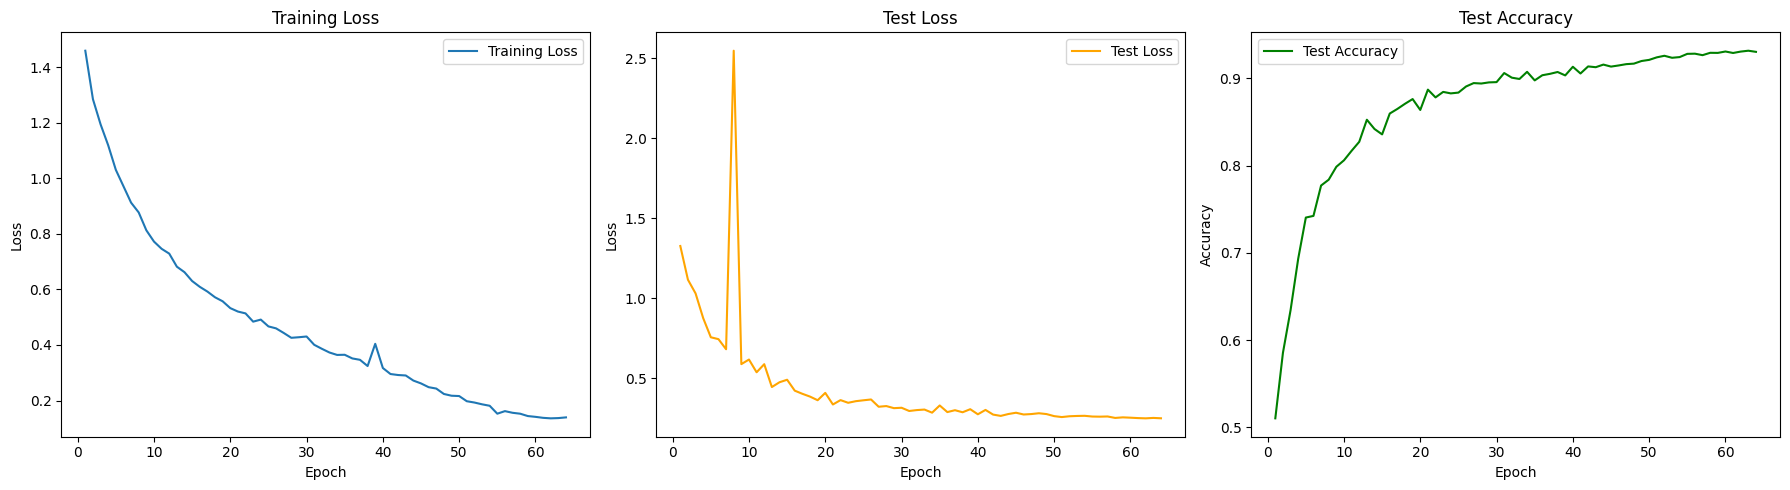

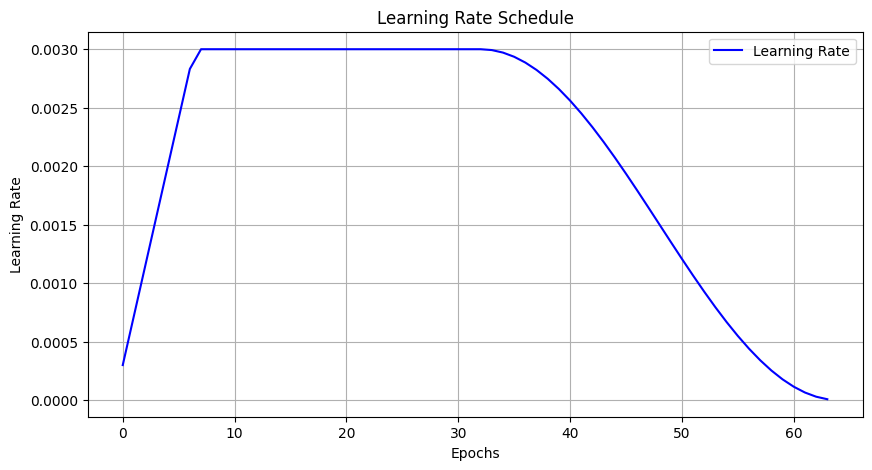

Accuracy of the network on the 10000 test images: 93.04%


In [37]:
# 保存结果
import pandas as pd
import matplotlib.pyplot as plt

results_df = pd.DataFrame({
    'Epoch': range(1, num_epochs + 1),
    'Training Loss': losses,
    'Test Loss': test_losses,
    'Test Accuracy': accuracies
})

results_df.to_excel('training_results_Variant4.xlsx', index=False)

# 可视化
plt.figure(figsize=(18, 5))

# 训练损失曲线
plt.subplot(1, 3, 1)
plt.plot(results_df['Epoch'], results_df['Training Loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# 测试损失曲线
plt.subplot(1, 3, 2)
plt.plot(results_df['Epoch'], results_df['Test Loss'], label='Test Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss')
plt.legend()

# 测试准确率曲线
plt.subplot(1, 3, 3)
plt.plot(results_df['Epoch'], results_df['Test Accuracy'], label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_results_Variant4.jpg')
plt.show()

# 绘制学习率变化曲线
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), learning_rates, label='Learning Rate', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.legend()
plt.grid()
plt.savefig('lr_schedule_Variant4.png')  # 保存图像
plt.show()  # 显示图像

# 保存模型
torch.save(net.state_dict(), 'Variant4.pth')
# 保存模型信息
model_info = {
    "Optimizer": type(optimizer).__name__,
    "Initail lr": initial_lr,
    "max_lr": max_lr,
    "Weight Decay": optimizer.param_groups[0]['weight_decay'],
    "Network Architecture": str(net),
    "Data Augmentation": "Enhanced"
}

model_info_df = pd.DataFrame([model_info])
model_info_df.to_excel('model_info_variant4.xlsx', index=False)

net.eval()
correct, total = 0, 0
with torch.no_grad():
    for img, target in loader["test"]:
        img, target = img.to(device), target.to(device)
        
        # make prediction
        pred = net(img)
        
        # accumulate
        total += len(target)
        correct += (torch.argmax(pred, dim=1) == target).sum().item()

print(f"Accuracy of the network on the {total} test images: {100 * correct / total:.2f}%")

## 5. Variant 4
Changing the data augementation.  
Ref: https://zhuanlan.zhihu.com/p/49180361

In [38]:
# # prepare datasets
# # preprocessing pipeline for input images
# # 数据增强
# transformation = dict()
# for data_type in ("train", "test"):
#     is_train = data_type=="train"
#     if is_train:
#         # 训练集使用增强的数据增强
#         transformation[data_type] = tv_transforms.Compose([
#             # 随机裁剪和填充
#             tv_transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
#             # 随机水平翻转
#             tv_transforms.RandomHorizontalFlip(),
#             # 随机旋转
#             tv_transforms.RandomRotation(degrees=15),
#             # 随机仿射变换
#             tv_transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
#             # 颜色抖动
#             tv_transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#             # 转换为张量
#             tv_transforms.ToTensor(),
#             # 标准化
#             tv_transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
#             # 随机擦除
#             tv_transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)),
#         ])
#     else:
#         # 测试集只进行基本转换
#         transformation[data_type] = tv_transforms.Compose([
#             tv_transforms.ToTensor(),
#             tv_transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
#         ])
        
# num_workers = 2
# batch_size = 64
# dataset, loader = {}, {}
# for data_type in ("train", "test"):
#     is_train = data_type=="train"
#     dataset[data_type] = tv_datasets.CIFAR10(
#         root="./data", train=is_train, download=True, transform=transformation[data_type],
#     )
#     loader[data_type] = torch.utils.data.DataLoader(
#         dataset[data_type], batch_size=batch_size, shuffle=is_train, num_workers=num_workers,
#     )


In [39]:
# # some experimental setup
# from torch.optim import lr_scheduler

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# num_epochs = 64
# print_every = 200

# optim_name = "AdamW"
# optim_kwargs = dict(
#     lr=3e-4,
#     weight_decay=1e-6,
# )

In [40]:
# # 使用Variant2的网络架构
# net = nn.Sequential(
#     nn.Conv2d(3, 256, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.BatchNorm2d(256),
#     nn.Conv2d(256, 512, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.BatchNorm2d(512),
#     nn.Conv2d(512, 1024, 3, padding=1), nn.ReLU(inplace=True), nn.BatchNorm2d(1024),
#     nn.Conv2d(1024, 1024, 3, padding=1), nn.ReLU(inplace=True), nn.BatchNorm2d(1024),
#     nn.Conv2d(1024, 2048, 3, padding=1), nn.ReLU(inplace=True), nn.BatchNorm2d(2048),
#     nn.Conv2d(2048, 2048, 3, padding=1), nn.ReLU(inplace=True), nn.BatchNorm2d(2048),
#     nn.Conv2d(2048, 1024, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2), nn.BatchNorm2d(1024),
    
#     nn.Flatten(),
    
#     nn.Linear(1024 * 4 * 4, 2048), nn.ReLU(inplace=True), nn.Dropout(0.3), nn.BatchNorm1d(2048),
#     nn.Linear(2048, 1024), nn.ReLU(inplace=True), nn.Dropout(0.3), nn.BatchNorm1d(1024),
#     nn.Linear(1024, 512), nn.ReLU(inplace=True), nn.Dropout(0.3), nn.BatchNorm1d(512),
#     nn.Linear(512, 10),
# )
# # 移动到设备
# net.to(device)

# # 打印参数数量
# print(f"number of parameters: {sum(p.numel() for p in net.parameters() if p.requires_grad) / 1_000_000:.2f}M")



In [41]:
# # the network optimizer
# optimizer = getattr(optim, optim_name)(net.parameters(), **optim_kwargs)

# # loss function
# criterion = nn.CrossEntropyLoss()

# # 开启异常检测
# torch.autograd.set_detect_anomaly(True)

# # 训练循环
# losses = []
# accuracies = []
# test_losses = []

# for epoch in range(num_epochs):
#     # 训练阶段
#     net.train()
#     running_loss = 0.0
#     for i, (img, target) in enumerate(loader["train"]):
#         img, target = img.to(device), target.to(device)
        
#         pred = net(img)
#         loss = criterion(pred, target)
        
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         running_loss += loss.item()
        
#         if i % print_every == print_every - 1:
#             print(f"[epoch={epoch + 1:3d}, iter={i + 1:5d}] training loss: {running_loss / print_every:.3f}")
#             running_loss = 0.0
    
#     # 每个epoch结束后进行一次评估
#     net.eval()
#     test_loss = 0.0
#     correct = 0
#     total = 0
    
#     with torch.no_grad():
#         for img, target in loader["test"]:
#             img, target = img.to(device), target.to(device)
            
#             pred = net(img)
#             loss = criterion(pred, target)
            
#             test_loss += loss.item()
#             total += len(target)
#             correct += (torch.argmax(pred, dim=1) == target).sum().item()
    
#     # 计算平均损失和准确率
#     avg_test_loss = test_loss / len(loader["test"])
#     accuracy = correct / total
    
#     # 记录结果
#     losses.append(running_loss / print_every)
#     accuracies.append(accuracy)
#     test_losses.append(avg_test_loss)
    
#     print(f"Epoch {epoch + 1}: Test Loss: {avg_test_loss:.3f}, Accuracy: {100 * accuracy:.2f}%")

# print("Finished Training")

In [42]:
# # 保存结果
# import pandas as pd
# import matplotlib.pyplot as plt

# results_df = pd.DataFrame({
#     'Epoch': range(1, num_epochs + 1),
#     'Training Loss': losses,
#     'Test Loss': test_losses,
#     'Test Accuracy': accuracies
# })

# results_df.to_excel('training_results_Variant5.xlsx', index=False)

# # 可视化
# plt.figure(figsize=(18, 5))

# # 训练损失曲线
# plt.subplot(1, 3, 1)
# plt.plot(results_df['Epoch'], results_df['Training Loss'], label='Training Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training Loss')
# plt.legend()

# # 测试损失曲线
# plt.subplot(1, 3, 2)
# plt.plot(results_df['Epoch'], results_df['Test Loss'], label='Test Loss', color='orange')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Test Loss')
# plt.legend()

# # 测试准确率曲线
# plt.subplot(1, 3, 3)
# plt.plot(results_df['Epoch'], results_df['Test Accuracy'], label='Test Accuracy', color='green')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('Test Accuracy')
# plt.legend()

# plt.tight_layout()
# plt.savefig('training_results_Variant5.jpg')
# plt.show()

# # 保存模型
# torch.save(net.state_dict(), 'Variant5.pth')
# # 保存模型信息
# model_info = {
#     "Optimizer": type(optimizer).__name__,
#     "Learning Rate": optimizer.param_groups[0]['lr'],
#     "Weight Decay": optimizer.param_groups[0]['weight_decay'],
#     "Network Architecture": str(net),
#     "Data Augmentation": "Enhanced"
# }

# model_info_df = pd.DataFrame([model_info])
# model_info_df.to_excel('model_info_variant5.xlsx', index=False)

# net.eval()
# correct, total = 0, 0
# with torch.no_grad():
#     for img, target in loader["test"]:
#         img, target = img.to(device), target.to(device)
        
#         # make prediction
#         pred = net(img)
        
#         # accumulate
#         total += len(target)
#         correct += (torch.argmax(pred, dim=1) == target).sum().item()

# print(f"Accuracy of the network on the {total} test images: {100 * correct / total:.2f}%")